In [220]:
# 75.06 - 1C202 - TP2 
# Competencia de Machine learning
#
# https://www.kaggle.com/c/nlp-getting-started/overview
#
# Fuentes:
# https://realpython.com/python-keras-text-classification/
# https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28

# Importacion de librerias necesarias
import re, string, random, datetime
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Split y K-Fold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Importacion de Keras
# https://keras.io
from keras.models import Sequential, save_model, load_model
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Configuracion general
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [221]:
# Seccion de CONFIGURACION
# Path de entrada
train_path = 'data/processed/train.2020.08.02T23.42.48.056703.csv' #Cambiar por el archivo pre-procesado a usar!
test_path = 'data/processed/test.2020.08.02T23.42.48.056703.csv' #Cambiar por el archivo pre-procesado a usar!

# Configuracion del modelo
maxlen = 200
num_filters = 64
kernel_size = 32
embedding_dim = 200
embeddings_path = 'embeddings/glove.twitter.27B.200d.txt'
# Embeddings disponibles en:
# https://worksheets.codalab.org/bundles/0x4090ba96b8a444c2a44b2c47884c25f2

# Configuracion de entrenamiento
epochs = 15
verbose = False
batch_size = 32

# Canditad de folds para K-Fold Cross-Validation
num_folds = 2

In [222]:
# Funciones AUXILIARES
# Grafica para un modelo los resultados del entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validación')
    plt.title('Accuracy: validación y entrenamiento')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validación')
    plt.title('Loss: validación y entrenamiento')
    plt.legend()
    plt.show()

# Genera la matriz de embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # 0 es un indice reservado, sumamos 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [223]:
# Carga de los archivos del set de datos
# Set de train: carga
df_twitter_train = pd.read_csv(train_path, sep=',')
# Set de test: carga
df_twitter_test = pd.read_csv(test_path, sep=',')

# Print de los shapes
print('Shape train: ' + str(df_twitter_train.shape))
print('Shape test: ' + str(df_twitter_test.shape))

Shape train: (15226, 4)
Shape test: (3263, 3)


In [224]:
# Nos quedamos con X e y para entrenar
tweets = df_twitter_train['text'].values
y = df_twitter_train['target'].values

# Separamos X para el set de test
tweets_predict = df_twitter_test['text'].values

# Tokenizamos los textos
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)

# Convertimos a secuencias
X = tokenizer.texts_to_sequences(tweets)
X_predict = tokenizer.texts_to_sequences(tweets_predict)

# Calculamos el tamaño
vocab_size = len(tokenizer.word_index) + 1  # 0 es un indice reservado, sumamos 1

#PROBAR CON EL TOKENIZADOR DE NTK DE TWITTER

# Paddeamos a maxlen
X = pad_sequences(X, padding='post', maxlen=maxlen)
X_predict = pad_sequences(X_predict, padding='post', maxlen=maxlen)

# Generacion de la matriz de embeddings
embedding_matrix = create_embedding_matrix(embeddings_path,tokenizer.word_index, embedding_dim)

# Vemos que cobertura tenemos con los embeddings utilizados
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Cobertura de vocabulario: ' + str(nonzero_elements / vocab_size))

Cobertura de vocabulario: 0.7219241982507288


Total de folds:  2
------------------------------------------------------------------------
Entrenando, fold 1...
Puntaje de entrenamiento para el fold 1: loss de 0.00477946549654007; accuracy de 99.78983402252197%
Puntaje de validación para el fold 1: loss de 0.9287795424461365; accuracy de 87.20609545707703%


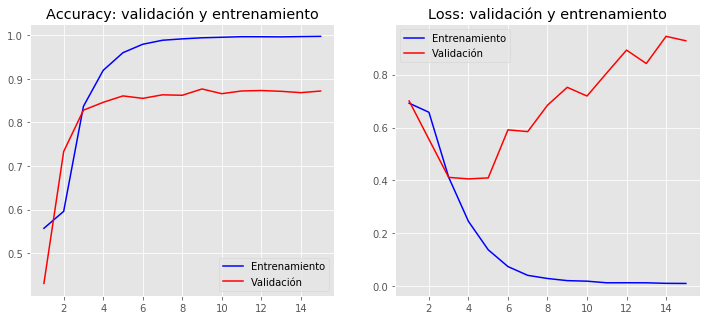

------------------------------------------------------------------------
Entrenando, fold 2...
Puntaje de entrenamiento para el fold 2: loss de 0.0035609020851552486; accuracy de 99.84237551689148%
Puntaje de validación para el fold 2: loss de 0.810141921043396; accuracy de 86.864572763443%


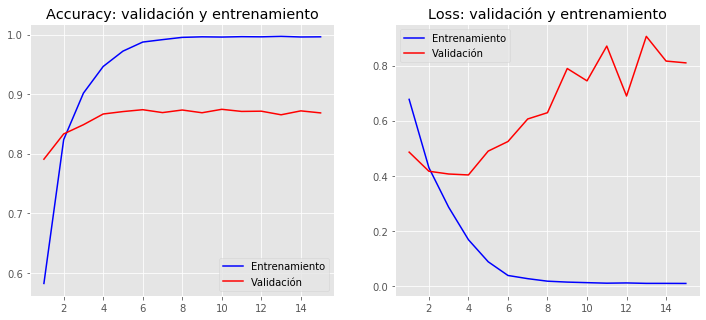



Puntaje promedio de entrenamiendo, para todos los folds:
> Accuracy: 99.81610476970673 (+- 0.026270747184753418)
> Loss: 0.004170183790847659


Puntaje promedio de validación, para todos los folds:
> Accuracy: 87.03533411026001 (+- 0.1707613468170166)
> Loss: 0.8694607317447662
------------------------------------------------------------------------


In [225]:
# Define el modelo a utilizar, con Conv1D
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Dropout(0.5))    
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu', padding="valid", strides=3))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='sigmoid', padding="valid", strides=9))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.5))    
    model.add(layers.Dense(num_filters, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid', name="predictions"))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Definimos y entrenamos el modelo
# K-Fold Cross Validation

# Path de para guardar los modelos
model_path = 'models/TP2.Keras.Conv1D.Iter.'

# Definimos los arrays para guardar los resultados
# Train
acc_per_fold_train = []
loss_per_fold_train = []
# Validacion
acc_per_fold_validation = []
loss_per_fold_validation = []

# Definomos el K-fold Cross Validator a usar
kfold = KFold(n_splits=num_folds, shuffle=True)

# Hacemos el bucle para la cantidad de folds definidos
fold_no = 1
print('Total de folds: ', num_folds)
for train, validation in kfold.split(X, y):

    # Imprimimos el progreso
    print('------------------------------------------------------------------------')
    print(f'Entrenando, fold {fold_no}...')

    # Definimos la arquitectura del modelo
    model = create_model(num_filters = num_filters,
                         kernel_size = kernel_size,
                         vocab_size = vocab_size,
                         embedding_dim = embedding_dim,
                         maxlen = maxlen)

    # Hacemos el fit
    history = model.fit(X[train], y[train],
                        epochs = epochs,
                        verbose = verbose,
                        validation_data = (X[validation], y[validation]),
                        batch_size = batch_size)      

    # Generamos la metrica de entrenamiento
    scores_train = model.evaluate(X[train], y[train], verbose=0)
    print(f'Puntaje de entrenamiento para el fold {fold_no}: {model.metrics_names[0]} de {scores_train[0]}; {model.metrics_names[1]} de {scores_train[1]*100}%')
    acc_per_fold_train.append(scores_train[1] * 100)
    loss_per_fold_train.append(scores_train[0])

    # Generamos la metrica de test
    scores_validation = model.evaluate(X[validation], y[validation], verbose=0)
    print(f'Puntaje de validación para el fold {fold_no}: {model.metrics_names[0]} de {scores_validation[0]}; {model.metrics_names[1]} de {scores_validation[1]*100}%')
    acc_per_fold_validation.append(scores_validation[1] * 100)
    loss_per_fold_validation.append(scores_validation[0])

    # Guardamos el modelo
    save_model(model, model_path + str(fold_no) + '.h5', save_format='h5')

    # Plotteamos el resultado final
    plot_history(history)

    # Incrementamos el fold
    fold_no = fold_no + 1
    
print('\n')
print('Puntaje promedio de entrenamiendo, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_train)} (+- {np.std(acc_per_fold_train)})')
print(f'> Loss: {np.mean(loss_per_fold_train)}')
print('\n')
print('Puntaje promedio de validación, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_validation)} (+- {np.std(acc_per_fold_validation)})')
print(f'> Loss: {np.mean(loss_per_fold_validation)}')
print('------------------------------------------------------------------------')

In [226]:
# Path de salida para el submission
submission_path = 'data/submits/submission.' + datetime.datetime.now().isoformat() + '.csv'
submission_path = submission_path.replace('-','.').replace(':','.')

# Cargamos el modelo con el mejor puntaje
filepath = model_path + str((acc_per_fold_validation.index(max(acc_per_fold_validation)))+1) + '.h5'
loaded_model = load_model(filepath, custom_objects=None, compile=True)

# Prediccion en base al modelo entrenado
y_predict = (loaded_model.predict(X_predict) > 0.5).astype('int32')

# Generacion del dataframe que generara el submit para la competencia
kaggle_submission = pd.DataFrame(df_twitter_test,columns = ['id'])
kaggle_submission['target'] = y_predict

kaggle_submission.to_csv(submission_path, index=False)

# Imprimimos un resumen de la operacion
print('Operación finalizada!\n')
print('Generado submit: \'' + submission_path + '\' - (' + str(len(kaggle_submission['target'].index)) + ') registros.')

Operación finalizada!

Generado submit: 'data/submits/submission.2020.08.02T23.52.29.346917.csv' - (3263) registros.


In [228]:
# Lo repetimos con todo el dataset
# Creamos y entrenamos nuevamente
model2 = create_model(num_filters = num_filters,
                         kernel_size = kernel_size,
                         vocab_size = vocab_size,
                         embedding_dim = embedding_dim,
                         maxlen = maxlen)

# Hacemos el fit
history = model2.fit(X, y,
                        epochs = epochs,
                        verbose = verbose,
                        batch_size = batch_size)

# Prediccion en base al modelo entrenado
y_predict = (model2.predict(X_predict) > 0.5).astype('int32')

In [229]:
# Path de salida para el submission
submission_path = 'data/submits/submission.' + datetime.datetime.now().isoformat() + '.csv'
submission_path = submission_path.replace('-','.').replace(':','.')

# Generacion del dataframe que generara el submit para la competencia
kaggle_submission = pd.DataFrame(df_twitter_test,columns = ['id'])
kaggle_submission['target'] = y_predict

kaggle_submission.to_csv(submission_path, index=False)

# Imprimimos un resumen de la operacion
print('Operación finalizada!\n')
print('Generado submit: \'' + submission_path + '\' - (' + str(len(kaggle_submission['target'].index)) + ') registros.')

Operación finalizada!

Generado submit: 'data/submits/submission.2020.08.03T00.03.46.261681.csv' - (3263) registros.
